# Using LSTM to analyze sentiments of IMDB Reviews

## Overview

Use LSTM for sentiment classification

## Runtime

~30 mins

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras
print ('tensorflow version :', tf.__version__)
print (tf.config.experimental.list_physical_devices())

tensorflow version : 2.3.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## TF-GPU Debug
The following block tests if TF is running on GPU.

In [2]:
## This block is to tweak TF running on GPU
## You may comment this out, if you are not using GPU

## ---- start Memory setting ----
## Ask TF not to allocate all GPU memory at once.. allocate as needed
## Without this the execution will fail with "failed to initialize algorithm" error

from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)
## ---- end Memory setting ----

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5



## Define Some Parameters

## Step 1 - Download Data

In [3]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

print (info)
print()
print (imdb)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
      title     = {Learning Word

In [4]:
train_data, test_data = imdb['train'], imdb['test']

print ("train_data: ", len(train_data))
print ("test_data: ", len(test_data))

train_data:  25000
test_data:  25000


## Train / Test

In [5]:
import numpy as np

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


In [6]:
## Run this cell a few times to see a few reviews :-) 

import random

index = random.randint(0, len(training_sentences)-1)

print ('training_labels_final[{}]\n{}'.format(index, training_labels_final[index]))
print()
print ('training_sentences[{}]\n{}'.format(index, training_sentences[index]))


training_labels_final[23172]
1

training_sentences[23172]
I saw this movie in 1976, my first year of living in New York. I went on to live there for the next 26 years,but never saw anything as delicate and beautiful again as this small TV movie. It was part of a PBS series as I recall, and I've never forgotten it. <br /><br />There are no sex scenes to speak of, just delicate, moving, extraordinarily touching moments full of tension and excitement, all set within a conservative, Boston (I think), World War 1 environment where women played the role of devoted wife awaiting the return of husband from the war, and did not seek out a career and financial independence. Frances Lee McCain is superb in the role of career photographer and I have spent the next 30 odd years searching for her in equally challenging roles to no avail.<br /><br />There has to be a video of this movie? Sure it should be on DVD but surely at least a video?


## Define Parameters

In [7]:
VOCAB_SIZE = 10000 # consider top-N words
OOV_TOK = "<OOV>"
EMBEDDING_DIM = 32
MAX_SEQ_LENGTH = 120
TRUNC_TYPE='post'
PADDING_TYPE='post'

## Vectorize Text

In [8]:
def sample_from_dict(d, sample=10):
    import random
    
    keys = random.sample(list(d), sample)
    values = [d[k] for k in keys]
    return dict(zip(keys, values))

In [9]:
## Tokeninze

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer (num_words=VOCAB_SIZE, oov_token=OOV_TOK)
tokenizer.fit_on_texts(training_sentences)

print ('document count :', tokenizer.document_count)
print ('word count :', len(tokenizer.word_counts))

print()
print ('word counts :', sample_from_dict(tokenizer.word_counts))
print()
print ('word index', sample_from_dict(tokenizer.word_index))

document count : 25000
word count : 88582

word counts : {'rebarba': 1, 'bakhtiari': 6, 'eliana': 1, 'astronishing': 1, 'contrives': 8, 'ezra': 8, "colman's": 12, 'hormone': 8, 'pcp': 2, 'scamp': 2}

word index {'weis': 57692, "weiss's": 81964, 'acquart': 30224, 'ploys': 40797, "'smoke'": 58100, 'disobeying': 31978, "micheaux's": 84889, 'brend': 85213, 'cultivated': 19074, 'gambler': 11594}


In [10]:
## Pad the sequences

from tensorflow.keras.preprocessing.sequence import pad_sequences

training_sequences = tokenizer.texts_to_sequences(training_sentences)

max_seq_length_actual = max([len(x) for x in training_sequences])

print('max_seq_length_actual :', max_seq_length_actual)
print ('we will limit to MAX_SEQ_LENGTH :', MAX_SEQ_LENGTH)

training_sequences_padded = pad_sequences(training_sequences, maxlen=MAX_SEQ_LENGTH, 
                                          truncating=TRUNC_TYPE) 

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_sequences_padded = pad_sequences(testing_sequences,maxlen=MAX_SEQ_LENGTH)


max_seq_length_actual : 2493
we will limit to MAX_SEQ_LENGTH : 120


In [11]:
## print out some text

import random

index = random.randint(0, len(training_sentences)-1)

print ('training sentence [{}]\n{}'.format(index,training_sentences[index]))
print()
print ('training seq [{}]\n{}'.format(index,training_sequences[index]))
print()
print ('training padded [{}]\n{}'.format(index, training_sequences_padded[index]))

training sentence [13469]
Kubrick meets King. It sounded so promising back in the spring of 1980, I remember. Then the movie came out, and the Kubrick cultists have been bickering with the King cultists ever since.<br /><br />The King cultists say Stanley Kubrick took a great horror tale and ruined it. The Kubrick cultists don't give a damn about King's story. They talk about Steadicams, tracking shots, camera angles.This is a film, they insist: It should be considered on its own. As it happens, both camps are correct. Unfortunately.<br /><br />If one views it purely as an adaptation of King's novel, "The Shining" is indeed a failure, a wasted opportunity, a series of botched narrative gambits. <br /><br />I used to blame that on Kubrick's screenwriter. The writer Diane Johnson (author of Le Marriage, L'Affaire, Le Divorce, etc.) has a reputation as an novelist of social manners. Maybe she was chosen for her subtle grasp of conjugal relations or family dynamics. But the little blue-col

## Build a Model

In [12]:
## Model 1  : Single LSTM layer
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQ_LENGTH),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 32)           320000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               49664     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 377,985
Trainable params: 377,985
Non-trainable params: 0
_________________________________________________________________


In [ ]:
## Model 2 - Bidirectional LSTM

# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQ_LENGTH),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])
# model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# model.summary()

In [13]:
## Model 3 - Two LSTM layers

# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQ_LENGTH),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])
# model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# model.summary()

## Train

In [14]:
%%time 

num_epochs = 10
history = model.fit(training_sequences_padded, training_labels_final, 
                    epochs=num_epochs, 
                    validation_data=(testing_sequences_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 11s 14ms/step - loss: 0.4470 - accuracy: 0.7861 - val_loss: 0.3513 - val_accuracy: 0.8478
Epoch 2/10
782/782 [==============================] - 12s 16ms/step - loss: 0.2821 - accuracy: 0.8870 - val_loss: 0.3703 - val_accuracy: 0.8419
Epoch 3/10
782/782 [==============================] - 16s 21ms/step - loss: 0.2075 - accuracy: 0.9198 - val_loss: 0.4193 - val_accuracy: 0.8329
Epoch 4/10
782/782 [==============================] - 18s 22ms/step - loss: 0.1378 - accuracy: 0.9484 - val_loss: 0.5390 - val_accuracy: 0.8289
Epoch 5/10
782/782 [==============================] - 15s 19ms/step - loss: 0.0900 - accuracy: 0.9671 - val_loss: 0.5889 - val_accuracy: 0.8208
Epoch 6/10
782/782 [==============================] - 15s 19ms/step - loss: 0.0627 - accuracy: 0.9782 - val_loss: 0.7538 - val_accuracy: 0.8213
Epoch 7/10
782/782 [==============================] - 12s 15ms/step - loss: 0.0415 - accuracy: 0.9862 - val_loss: 0.8775 - val_accuracy:

## See Training History

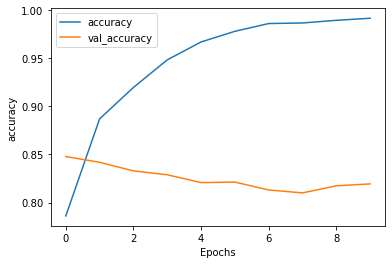

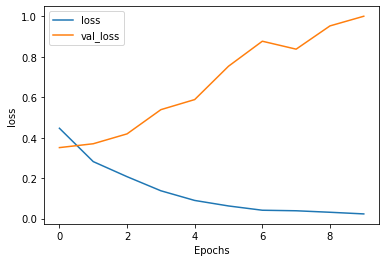

In [15]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Metrics

In [16]:
metric_names = model.metrics_names
print ("model metrics : " , metric_names)

metrics = model.evaluate(testing_sequences_padded, testing_labels_final)

for idx, metric in enumerate(metric_names):
    print ("Metric : {} = {:,.3f}".format (metric_names[idx], metrics[idx]))

model metrics :  ['loss', 'accuracy']
782/782 [==============================] - 5s 7ms/step - loss: 1.0011 - accuracy: 0.8194
Metric : loss = 1.001
Metric : accuracy = 0.819


## Predictions

In [17]:
import numpy as np
from math import ceil


print ("predicting on {:,} test data".format(len(testing_labels_final)))
# we need a ceiling for steps
predictions = model.predict(testing_sequences_padded)
print( 'predictions.shape: ', predictions.shape)

# ## for softmax
# # predictions2 = [ np.argmax(p) for p in predictions]

## binary
predictions2 = [0 if n < 0.5 else 1 for n in predictions]

np.set_printoptions(formatter={'float': '{: 0.2f}'.format})

print ('predictions : ' , predictions[:10])
print ('prediction2: ' , predictions2[:10])

predicting on 25,000 test data
predictions.shape:  (25000, 1)
predictions :  [[ 0.77]
 [ 0.99]
 [ 0.00]
 [ 0.00]
 [ 1.00]
 [ 1.00]
 [ 1.00]
 [ 1.00]
 [ 1.00]
 [ 1.00]]
prediction2:  [1, 1, 0, 0, 1, 1, 1, 1, 1, 1]


## Confusion Matrix

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(testing_labels_final, predictions2, labels = [0,1])
cm

array([[10426,  2074],
       [ 2441, 10059]])

[]

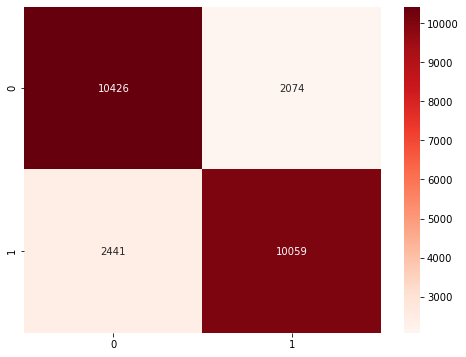

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (8,6))

# colormaps : cmap="YlGnBu" , cmap="Greens", cmap="Blues",  cmap="Reds"
sns.heatmap(cm, annot=True, cmap="Reds", fmt='d').plot()

## Predict on Custom Text

In [20]:
import random

## Choose random headlines
my_text = random.sample(training_sentences, 3)

## or write your own headlines
# my_text = ['this movie sucks!', 
#             'the movie was amazing!',
#             'the movie was just ok']



my_seq = tokenizer.texts_to_sequences(my_text)
my_seq_padded = pad_sequences(my_seq,  maxlen=MAX_SEQ_LENGTH, 
                               padding=PADDING_TYPE, truncating=TRUNC_TYPE )

my_predictions = model.predict(my_seq_padded)

my_predictions2 = [0 if n < 0.5 else 1 for n in my_predictions]  # binary
# my_predictions2 = [ np.argmax(p) for p in my_predictions]  # softmax

## print out

for i in range(0, len(my_text)):
    print ('my_text\n', my_text[i])
    print()
    print('prediction :', my_predictions2[i])
    print()
    print('============')

my_text
 This is a great movie, it shows what our government will to to other countries if we don't like their government. This isn't as bad as what Reagan and Bush number one did to South America, but the US still has no business messing around with other countries like this. This movies also proves that American media spouts government propaganda. This is exactly what they did to Aristide in Haiti. The reason this coup against Chavez didn't succeed is Chavez was elected with over 90% of the vote.<br /><br />This movie isn't just a political documentary, it would still be a great movie if it were a drama, it's amazing that this is real.<br /><br />The other reviewer is lying when he says "Chavez seizes the airwaves", the private media is running anti Chavez propaganda all the time.

prediction : 1

my_text
 I don't hand out "ones" often, but if there was ever a film that deserved this sort of attention, it's "Gas!" This is self-indulgent crap that reaches for some of the ambiance of M

## Explore Embeddings

You can load these embeddings into [embedding projector](https://projector.tensorflow.org/)

In [21]:
reverse_word_index = dict([(value, key) for (key, value) in tokenizer.word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


In [22]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 32)


In [23]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, VOCAB_SIZE):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

print ("embeddings wrote to vecs.tsv and meta.tsv")

embeddings wrote to vecs.tsv and meta.tsv
